# BT4222: CryptoCast

Numerical Data Analysis and Forecasting

## Imports and Config

In [ ]:
!pip install yfinance
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 4.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import numpy as np
import pandas as pd

from datetime import date, time, datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf
import pandas_datareader.data as web

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier

from sklearn.metrics import f1_score, classification_report

from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
lookback_date = date(2019,7,1)
earliest_date = date(2019,10,1)
latest_date = date(2022,10,1)
split_date = latest_date - relativedelta(days=365)

price = 'Close'

In [ ]:
coins = ["BTC","ETH","BNB","XRP","ADA","DOGE","MATIC","TRX", "LEO", "LTC"]
yf_coins = [f'{coin}-USD' for coin in coins]

## Data Import

In [ ]:
df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Coin'])
for coin in yf_coins:
  data = web.get_data_yahoo(coin, start = lookback_date ,end = latest_date)
  data.reset_index(inplace=True)
  data['Coin'] = coin.split('-')[0]
  data['Date'] = data['Date'].dt.date
  df = pd.concat([df, data], axis=0)
df.to_csv("ohlcv.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Coin
0,2019-07-01,10796.930664,11206.439453,10089.314453,10583.134766,10583.134766,29378589324,BTC
1,2019-07-02,10588.683594,10912.188477,9737.884766,10801.677734,10801.677734,31015895223,BTC
2,2019-07-03,10818.156250,11968.078125,10818.156250,11961.269531,11961.269531,30796494294,BTC
3,2019-07-04,11972.718750,12006.075195,11166.569336,11215.437500,11215.437500,25920294033,BTC
4,2019-07-05,11203.102539,11395.661133,10874.964844,10978.459961,10978.459961,23838480210,BTC


In [ ]:
sentiment = pd.read_csv('sentiment.csv')
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.date
sentiment.head()

,Date,polarity,subjectivity
0,2019-01-07,0.211240,0.341574
1,2019-02-07,0.246338,0.319595
2,2019-03-07,0.181414,0.066015
3,2019-04-07,0.163393,0.218119
4,2019-05-07,0.050206,0.075301


## Exploratory Data Analysis

Dropdown(description='List', options=('BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'MATIC', 'TRX', 'LEO', 'LTC')…

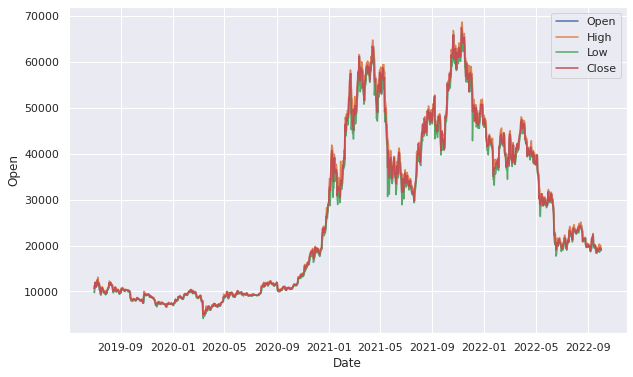

In [ ]:
default = 'BTC'
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(data = df[df['Coin'] == default], x = 'Date', y = 'Open', label='Open')
sns.lineplot(data = df[df['Coin'] == default], x = 'Date', y = 'High', label='High')
sns.lineplot(data = df[df['Coin'] == default], x = 'Date', y = 'Low', label='Low')
sns.lineplot(data = df[df['Coin'] == default], x = 'Date', y = price, label=price)

w = widgets.Dropdown(
    options=coins,
    value = default,
    description='List',
)
display(w)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        sns.lineplot(data = df[df['Coin'] == change['new']], x = 'Date', y = 'Open', label='Open')
        sns.lineplot(data = df[df['Coin'] == change['new']], x = 'Date', y = 'High', label='High')
        sns.lineplot(data = df[df['Coin'] == change['new']], x = 'Date', y = 'Low', label='Low')
        sns.lineplot(data = df[df['Coin'] == change['new']], x = 'Date', y = price, label=price)

w.observe(on_change)

Dropdown(description='List', options=('BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'MATIC', 'TRX', 'LEO', 'LTC')…

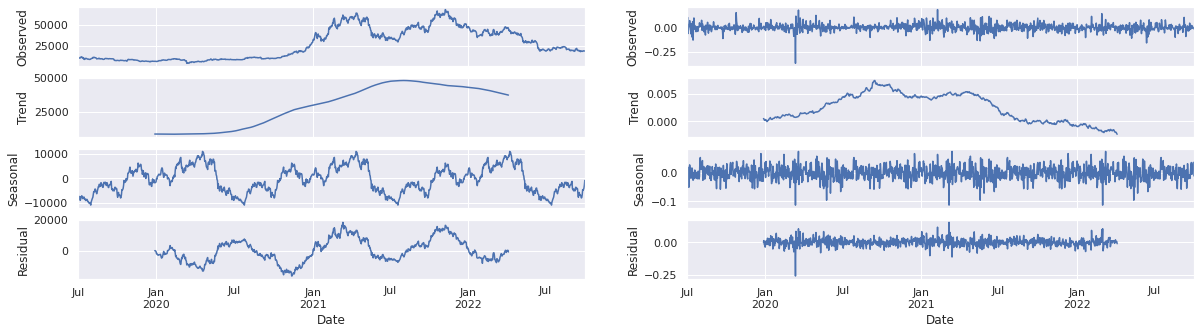

In [ ]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

default = 'BTC'
period = 360
s_data = df.set_index('Date')
s_data.index = pd.to_datetime(s_data.index)
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20,5))
decom = seasonal_decompose(s_data[s_data['Coin']==default][price], period=period)
decom_ret = seasonal_decompose(s_data[s_data['Coin']==default][price].pct_change().fillna(0), period=period)
plotseasonal(decom, axes[:,0])
plotseasonal(decom_ret, axes[:,1])

w = widgets.Dropdown(
    options=coins,
    value = default,
    description='List',
)
display(w)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20,5))
        decom = seasonal_decompose(s_data[s_data['Coin']==change['new']][price], period=period)
        decom_ret = seasonal_decompose(s_data[s_data['Coin']==change['new']][price].pct_change().fillna(0), period=period)
        plotseasonal(decom, axes[:,0])
        plotseasonal(decom_ret, axes[:,1])

w.observe(on_change)

Dropdown(description='List', options=('BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'MATIC', 'TRX', 'LEO', 'LTC')…

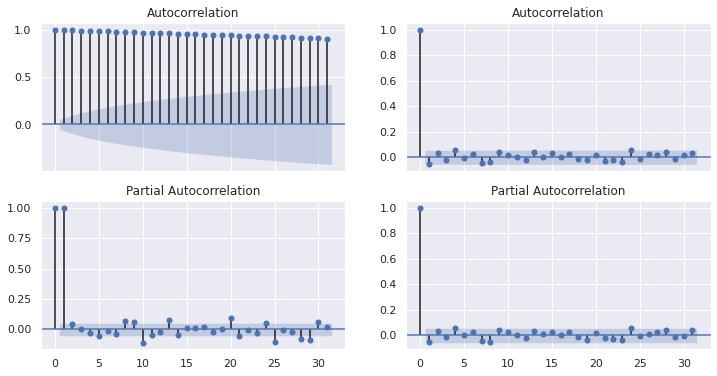

In [ ]:
default = 'BTC'
s_data = df.set_index('Date')
s_data.index = pd.to_datetime(s_data.index)
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12,6))
plot_acf(s_data[s_data['Coin']==default][price], ax=axes[0,0])
plot_pacf(s_data[s_data['Coin']==default][price], ax=axes[1, 0])
plot_acf(s_data[s_data['Coin']==default][price].pct_change().fillna(0), ax=axes[0,1])
plot_pacf(s_data[s_data['Coin']==default][price].pct_change().fillna(0), ax=axes[1,1])

w = widgets.Dropdown(
    options=coins,
    value = default,
    description='List',
)
display(w)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12,6))
        plot_acf(s_data[s_data['Coin']==change['new']][price], ax=axes[0,0])
        plot_pacf(s_data[s_data['Coin']==change['new']][price], ax=axes[1, 0])
        plot_acf(s_data[s_data['Coin']==change['new']][price].pct_change().fillna(0), ax=axes[0,1])
        plot_pacf(s_data[s_data['Coin']==change['new']][price].pct_change().fillna(0), ax=axes[1,1])

w.observe(on_change)

In [ ]:
pivot_df = df.set_index('Date').pivot(columns=['Coin'], values=[price])
pivot_df.columns = [x[1] for x in pivot_df.columns]

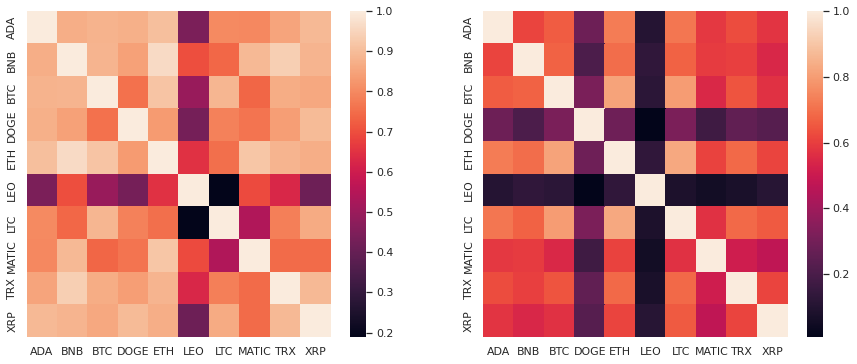

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(15,6))
sns.heatmap(pivot_df.corr(), ax=axes[0])
sns.heatmap(pivot_df.pct_change().fillna(0).corr(), ax=axes[1])

In [ ]:
max_corrs = pivot_df.corr().replace(1, 0.5).idxmax(axis=1).to_dict()
min_corrs = pivot_df.corr().replace(1, 0.5).idxmin(axis=1).to_dict()

In [ ]:
cols =['Coin', 'Value', 'ADF Statistic', 'p-value']
adf_res = pd.DataFrame(columns=cols)
for coin in coins:
  res = adfuller(pivot_df[coin])
  adf_res = adf_res.append(dict(zip(cols, [coin, price, res[0], res[1]])), ignore_index=True)
  res_ret = adfuller(pivot_df[coin].pct_change().fillna(0))
  adf_res = adf_res.append(dict(zip(cols, [coin, f'{price}_Return', res_ret[0], res_ret[1]])), ignore_index=True)
adf_res.pivot(columns=['Value'], index=['Coin'], values=['p-value'])

p-value              
Value     Close  Close_Return
Coin                         
ADA    0.501706  2.660100e-18
BNB    0.541211  8.319166e-14
BTC    0.615533  2.577829e-29
DOGE   0.242951  2.242799e-30
ETH    0.572449  4.170639e-18
LEO    0.798718  9.957087e-12
LTC    0.516232  3.660082e-24
MATIC  0.550486  3.239097e-21
TRX    0.512611  4.143199e-13
XRP    0.168509  0.000000e+00

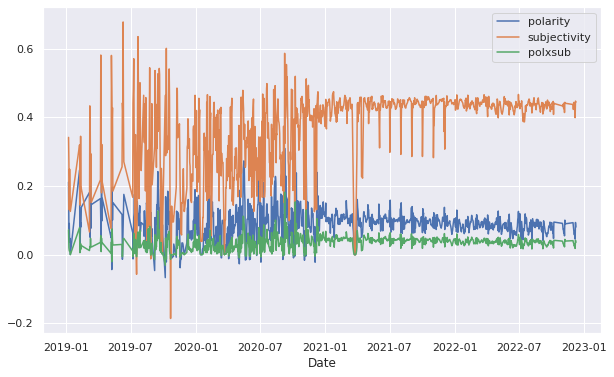

In [ ]:
sentiment['polxsub'] = sentiment['polarity'] * sentiment['subjectivity']
sentiment.set_index(['Date']).plot()

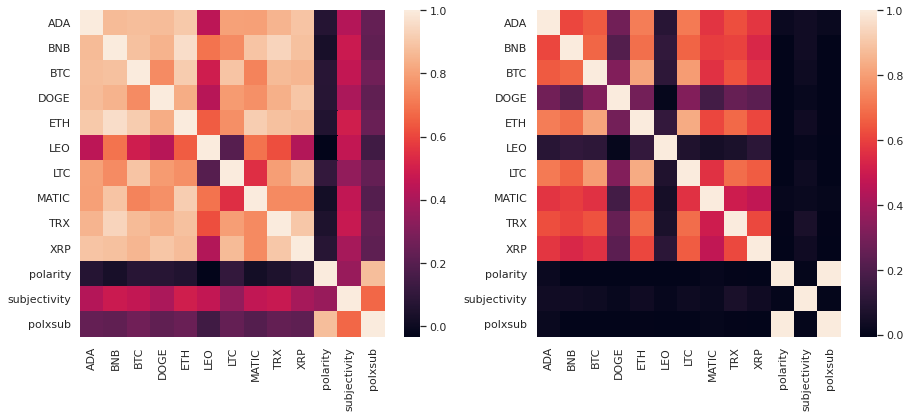

In [ ]:
sentiment_pivot_df = pivot_df.merge(sentiment.set_index(['Date'])[['polarity', 'subjectivity', 'polxsub']], left_index=True, right_index=True)
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(15,6))
sns.heatmap(sentiment_pivot_df.corr(), ax=axes[0])
sns.heatmap(sentiment_pivot_df.pct_change().fillna(0).corr(), ax=axes[1])

## Feature Engineering

In [ ]:
df[f'{price}_return'] = df.groupby(['Coin'])[price].pct_change() 
df[f'{price}_open_close'] = (df['Close'] - df['Open'])/df['Open']
df[f'{price}_high_low'] = (df['High'] - df['Low'])/df['Low'] 

for p in [3,7,20]:
  df[f'{price}_sma_{p}'] = df.groupby(['Coin'])[f'{price}_return'].rolling(p).mean().values
  df[f'{price}_ema_{p}'] = df.groupby(['Coin'])[f'{price}_return'].ewm(span=p, adjust=False).mean().values
  df[f'{price}_std_{p}'] = df.groupby(['Coin'])[f'{price}_return'].rolling(p).std().values

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

df_mtd_group = df.groupby(['Coin', 'Month'])
df_ytd_group = df.groupby(['Coin', 'Year'])

df[f'{price}_mtd'] = df[f'{price}_return']/df_mtd_group[f'{price}_return'].transform('first') - 1.0
df[f'{price}_ytd'] = df[f'{price}_return']/df_ytd_group[f'{price}_return'].transform('first') - 1.0

df['max_corr_coin_return'] = df['Coin'].groupby(df['Coin']).transform(lambda x: df[df['Coin'] == max_corrs[x.name]][f'{price}_return'].values)
df['min_corr_coin_return'] = df['Coin'].groupby(df['Coin']).transform(lambda x: df[df['Coin'] == min_corrs[x.name]][f'{price}_return'].values)

df['target'] = df.groupby(['Coin'])[f'{price}_return'].shift(-1).fillna(1)
df['target'] = np.where(df['target'] > 0, 1, 0)

lstm_df = df.copy(deep = True)

df = df[df['Date'].dt.date > earliest_date]

df.to_csv('all_data.csv')
lstm_df.to_csv('all_data_historic.csv')

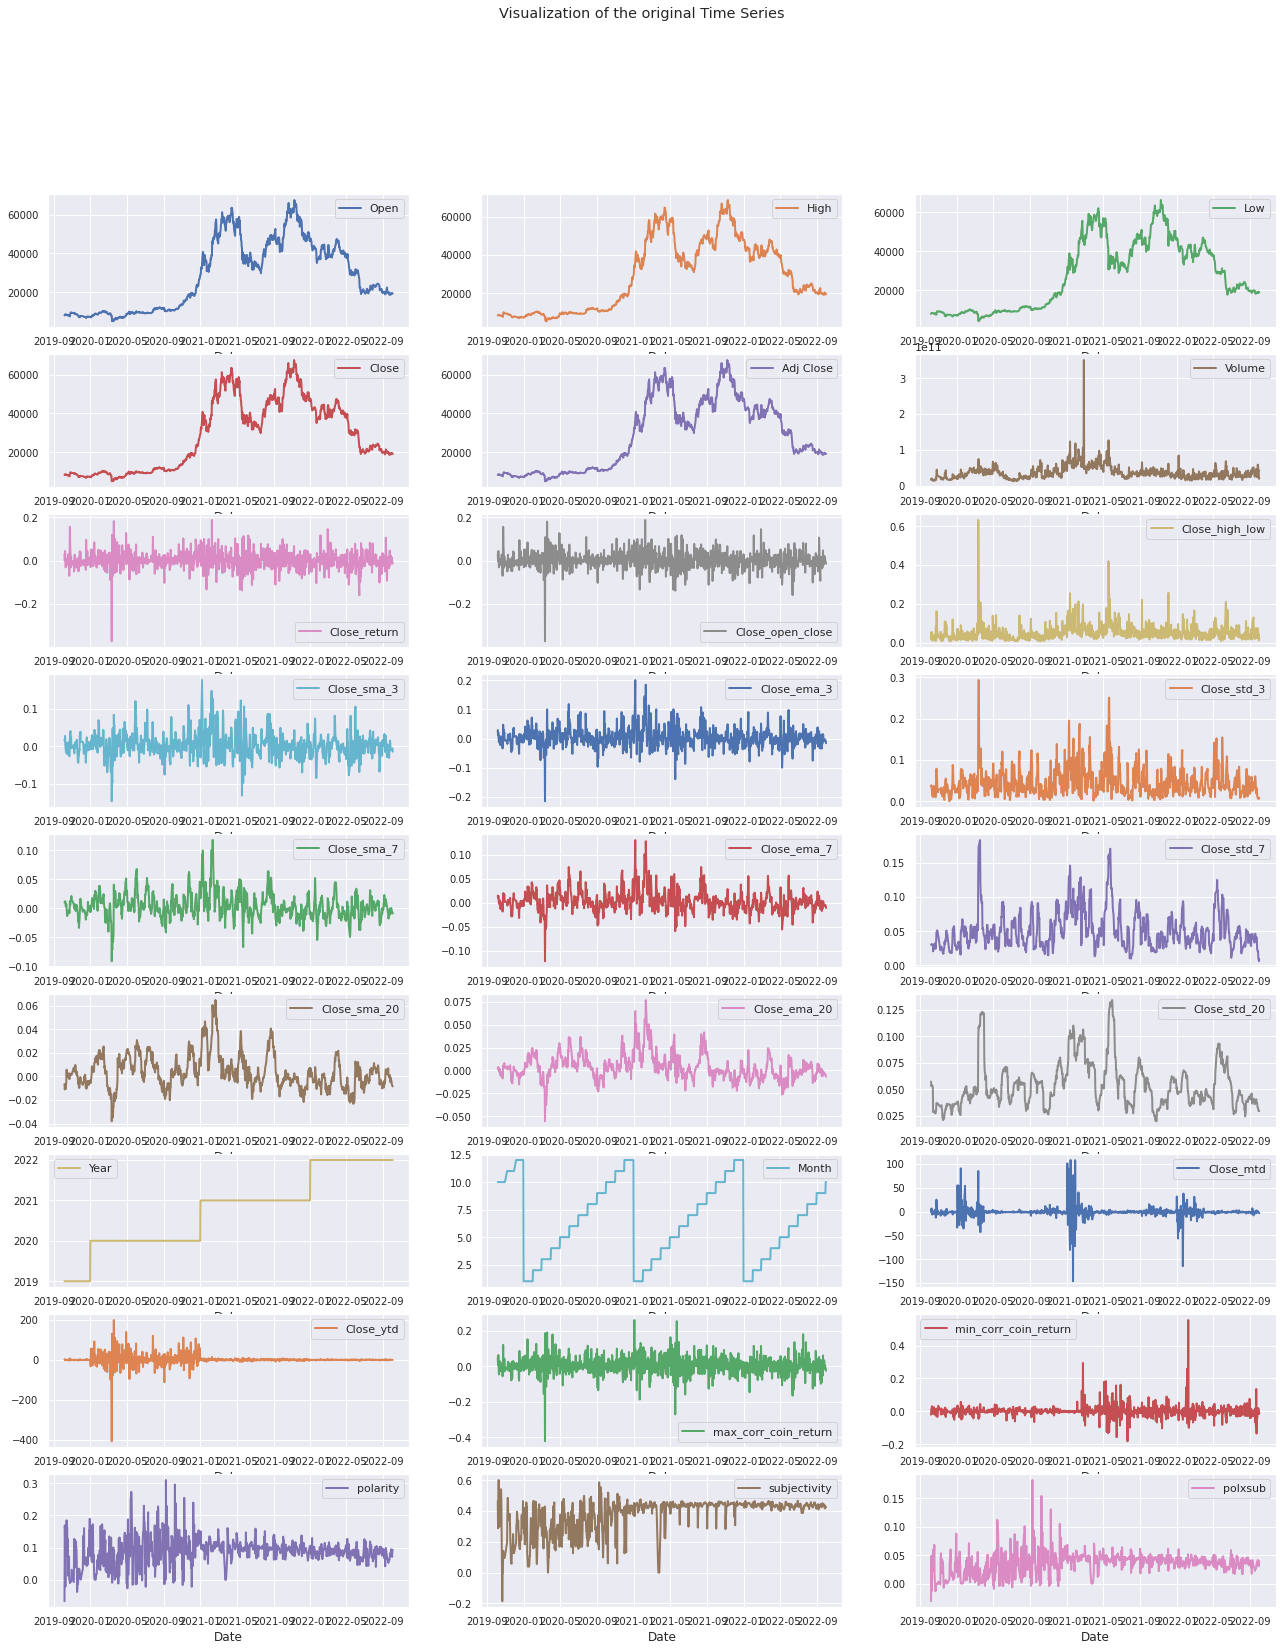

In [ ]:
df[df['Coin']=='BTC'].set_index(['Date']).drop(['target'], axis=1).merge(sentiment.set_index(['Date'])[['polarity', 'subjectivity', 'polxsub']], left_index=True, right_index=True).plot(subplots=True,
        layout=(9, 3),
        figsize=(22,26),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

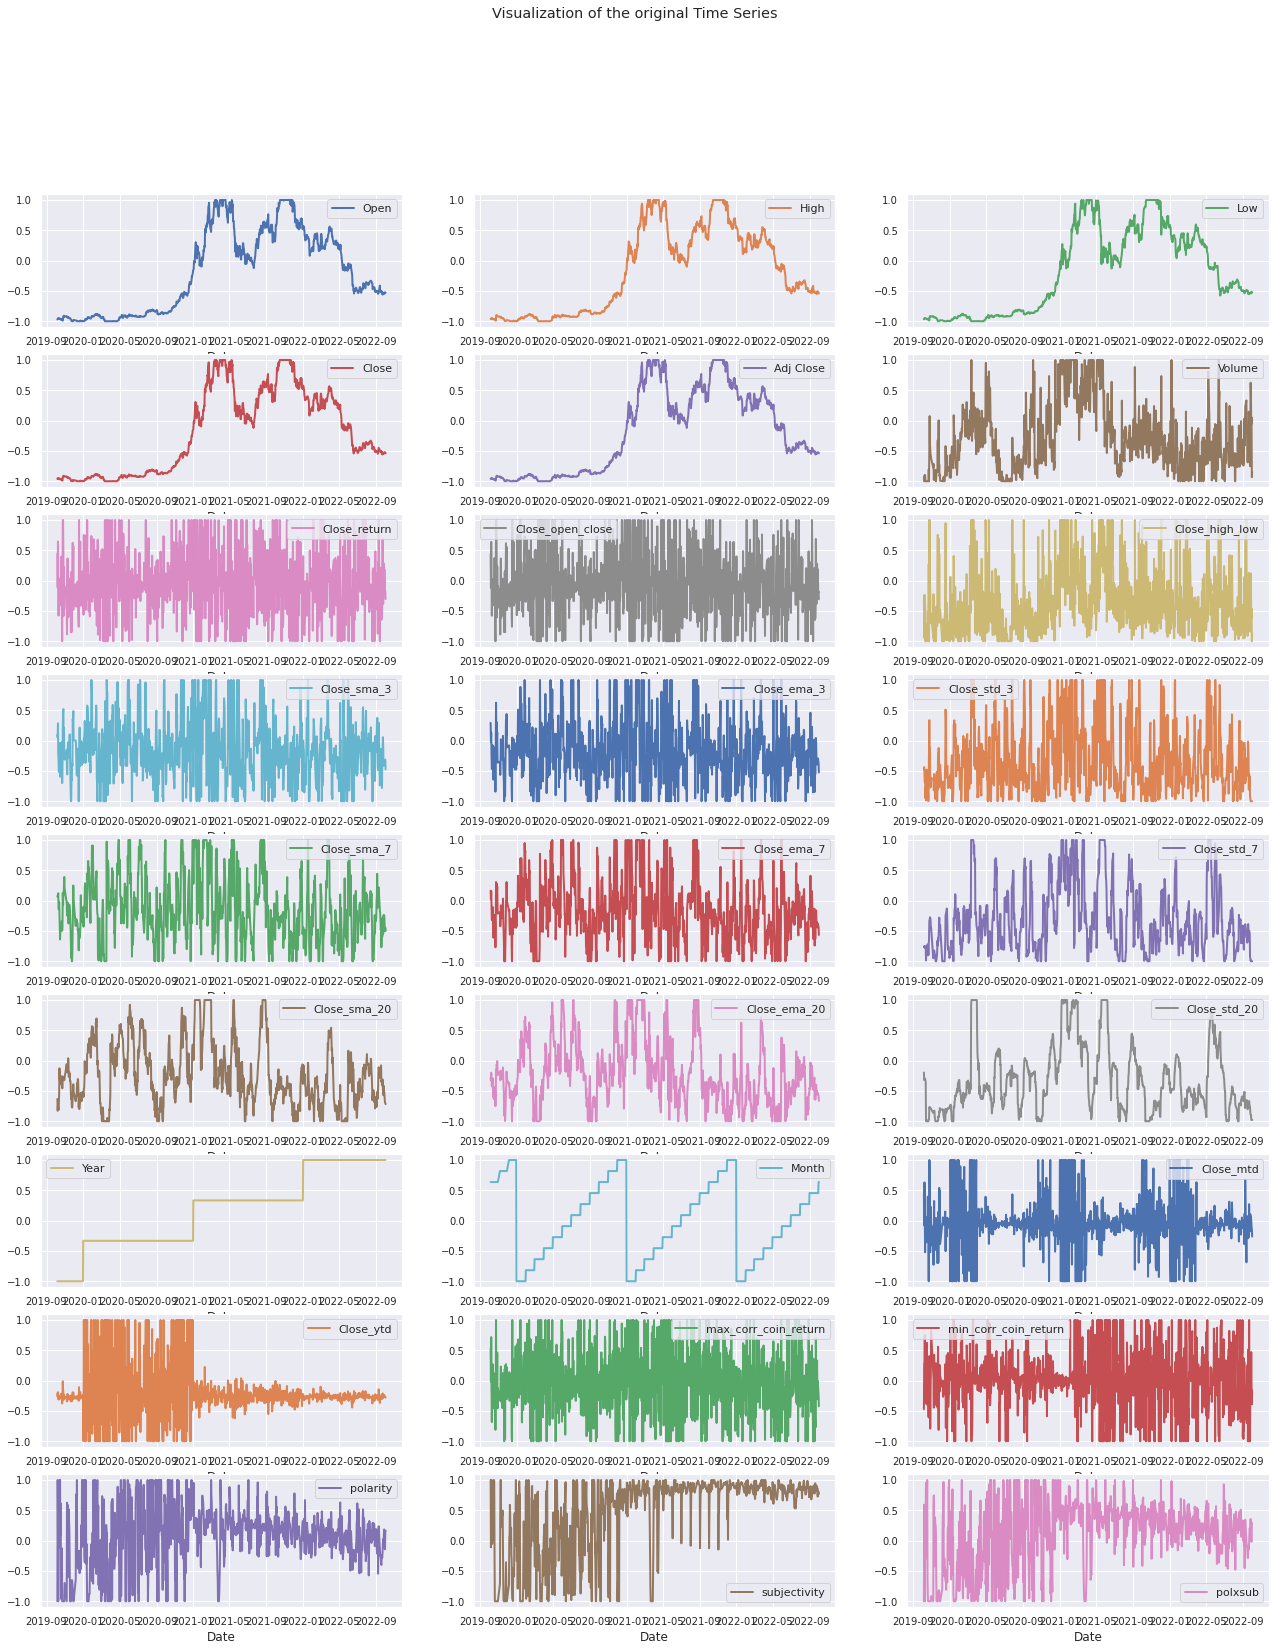

In [ ]:
all_cols = df[df['Coin']=='BTC'].set_index(['Date']).drop(['target'], axis=1).merge(sentiment.set_index(['Date'])[['polarity', 'subjectivity', 'polxsub']], left_index=True, right_index=True)
for col in all_cols.columns:
  if(col is not 'Coin'):
    all_cols[col] = all_cols[col].clip(all_cols[col].quantile(0.05) ,all_cols[col].quantile(0.95))
    scaler = MinMaxScaler((-1, 1))
    all_cols[col] = scaler.fit_transform(all_cols[[col]])
all_cols.plot(subplots=True,
        layout=(9, 3),
        figsize=(22,26),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

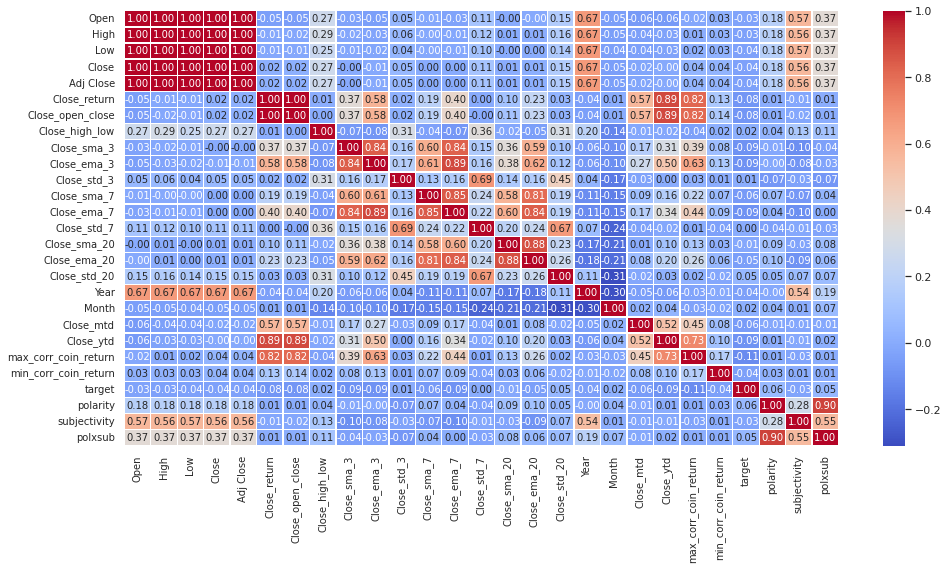

In [ ]:
corr_matrix = df[df['Coin']=='BTC'].set_index(['Date']).merge(sentiment.set_index(['Date'])[['polarity', 'subjectivity', 'polxsub']], left_index=True, right_index=True).corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

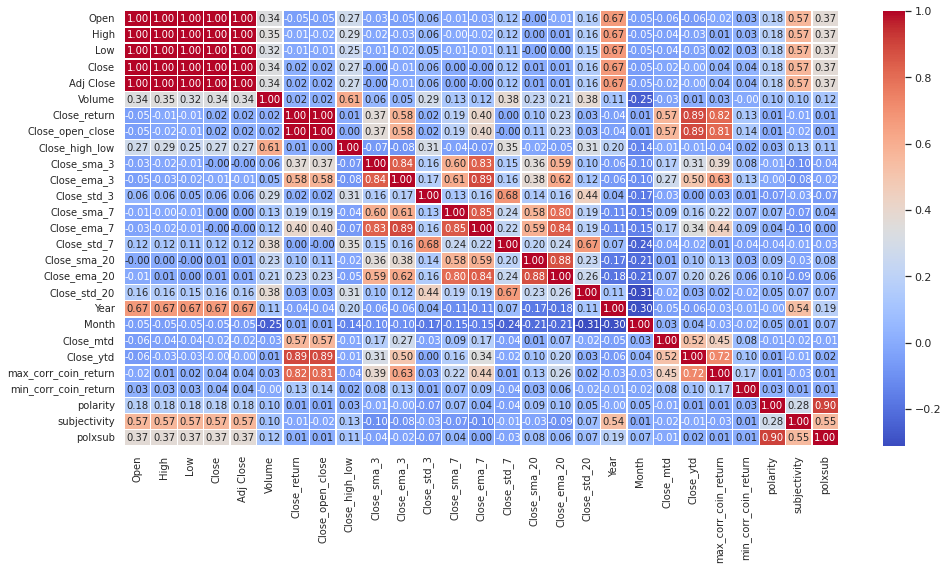

In [ ]:
corr_matrix = all_cols.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
sentiment.set_index(['Date'], inplace=True)
sentiment['subjectivity_change'] = sentiment['subjectivity'].pct_change()
sentiment['polarity_change'] = sentiment['polarity'].pct_change()

## Modelling

In [ ]:
feature_columns = ['return', 'open_close', 'high_low', 'sma_3', 'sma_7', 'sma_20', 'ema_3', 'ema_7', 'ema_20', 'std_3', 'std_7', 'std_20', 'mtd', 'ytd']
features = [f'{price}_{col}' for col in feature_columns] + ['max_corr_coin_return', 'min_corr_coin_return']
target = 'target'

In [ ]:
models = [LogisticRegression, GaussianNB, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier]
stack_models = [LogisticRegression, GaussianNB, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier]

### Naive Models Only Financial Data

In [ ]:
classes = ['Up', 'Down']
metrics = ['Precision', 'Recall', 'F1 Score']
res = pd.DataFrame(columns = pd.MultiIndex.from_product([classes, metrics], names=['Direction', 'Metric']))
res['Model'] = ''
res['Weighted Avg F1'] = np.nan

for sk_model in tqdm(models, position=0):
  X = df[features+['Date']]
  y = df[target]
  split_indices = X['Date'].dt.date <= split_date, X['Date'].dt.date > split_date
  X_train, X_test = X[split_indices[0]].drop(['Date'], axis=1), X[split_indices[1]].drop(['Date'], axis=1)
  y_train, y_test = y[split_indices[0]], y[split_indices[1]]
  for f in features:
    X_train_percs = (X_train[f].quantile(0.05), X_train[f].quantile(0.95))
    scaler = MinMaxScaler((-1, 1))
    X_train[f] = X_train[f].clip(X_train_percs[0], X_train_percs[1])
    X_train[f] = scaler.fit_transform(X_train[[f]])
    X_test[f] = X_test[f].clip(X_train_percs[0], X_train_percs[1])
    X_test[f] = scaler.transform(X_test[[f]])
  model = None
  if(sk_model in models[-2:]):
    model = sk_model(estimators=[(est.__name__, est()) for est in stack_models])
  else:
    model = sk_model()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred, output_dict=True)
  vals = [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], 
                    report['1']['precision'], report['1']['recall'], report['1']['f1-score'], 
                    model.__class__.__name__, report['weighted avg']['f1-score']]
  res = res.append(dict(zip(res.columns, vals)), ignore_index=True)
res.set_index(['Model'], inplace=True)
res

100%|██████████| 9/9 [01:07<00:00,  7.47s/it]


Direction                         Up                          Down            \
Metric                     Precision    Recall  F1 Score Precision    Recall   
Model                                                                          
LogisticRegression          0.569655  0.223727  0.321276  0.511755  0.828004   
GaussianNB                  0.564502  0.353196  0.434522  0.523353  0.722712   
SVC                         0.551142  0.300650  0.389064  0.513381  0.750827   
DecisionTreeClassifier      0.497611  0.451246  0.473295  0.489930  0.536384   
RandomForestClassifier      0.545965  0.421452  0.475696  0.522148  0.643330   
AdaBoostClassifier          0.549275  0.410618  0.469932  0.522807  0.657111   
GradientBoostingClassifier  0.544598  0.406826  0.465736  0.519947  0.653804   
VotingClassifier            0.565686  0.426869  0.486570  0.533304  0.666483   
StackingClassifier          0.540193  0.364030  0.434951  0.514073  0.684675   

Direction                            Weighted Avg F1  
Metric                      F1 Score                  
Model                                                 
LogisticRegression          0.632554        0.475554  
GaussianNB                  0.607085        0.520049  
SVC                         0.609805        0.498470  
DecisionTreeClassifier      0.512105        0.492531  
RandomForestClassifier      0.576439        0.525627  
AdaBoostClassifier          0.582316        0.525632  
GradientBoostingClassifier  0.579243        0.521994  
VotingClassifier            0.592502        0.539073  
StackingClassifier          0.587234        0.510427

In [ ]:
classes = ['Up', 'Down']
metrics = ['Precision', 'Recall', 'F1 Score']
res = pd.DataFrame(columns = pd.MultiIndex.from_product([classes, metrics], names=['Direction', 'Metric']))
res['Model'] = ''
res['Coin'] = ''
res['Weighted Avg F1'] = np.nan

for coin in tqdm(coins, position=0):
  for sk_model in tqdm(models, position=0):
    coin_df = df[(df['Coin'] == coin)]
    X = coin_df[features]
    y = coin_df[target]
    X_train, X_test = X[:-366], X[-366:]
    y_train, y_test = y[:-366], y[-366:]
    for f in features:
      X_train_percs = (X_train[f].quantile(0.05), X_train[f].quantile(0.95))
      scaler = MinMaxScaler((-1, 1))
      X_train[f] = X_train[f].clip(X_train_percs[0], X_train_percs[1])
      X_train[f] = scaler.fit_transform(X_train[[f]])
      X_test[f] = X_test[f].clip(X_train_percs[0], X_train_percs[1])
      X_test[f] = scaler.transform(X_test[[f]])
    model = None
    if(sk_model in models[-2:]):
      model = sk_model(estimators=[(est.__name__, est()) for est in stack_models])
    else:
      model = sk_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    vals = [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], 
                    report['1']['precision'], report['1']['recall'], report['1']['f1-score'], 
                    model.__class__.__name__, coin, report['weighted avg']['f1-score']]
    res = res.append(dict(zip(res.columns, vals)), ignore_index=True)
res.loc[res.groupby(['Coin'])['Weighted Avg F1'].idxmax()].set_index('Coin')

100%|██████████| 10/10 [01:26<00:00,  8.60s/it]


Direction        Up                          Down                      \
Metric    Precision    Recall  F1 Score Precision    Recall  F1 Score   
Coin                                                                    
ADA        0.661654  0.453608  0.538226  0.545064  0.738372  0.627160   
BNB        0.589041  0.475138  0.525994  0.568182  0.675676  0.617284   
BTC        0.583333  0.552632  0.567568  0.543011  0.573864  0.558011   
DOGE       0.535270  0.701087  0.607059  0.560000  0.384615  0.456026   
ETH        0.549618  0.378947  0.448598  0.497872  0.664773  0.569343   
LEO        0.513514  0.318436  0.393103  0.521569  0.711230  0.601810   
LTC        0.546939  0.736264  0.627635  0.603306  0.396739  0.478689   
MATIC      0.597315  0.481081  0.532934  0.557604  0.668508  0.608040   
TRX        0.515873  0.375723  0.434783  0.550000  0.683938  0.609700   
XRP        0.552147  0.478723  0.512821  0.517241  0.589888  0.551181   

Direction                       Model Weighted Avg F1  
Metric                                                 
Coin                                                   
ADA                               SVC        0.580021  
BNB                  VotingClassifier        0.572138  
BTC            RandomForestClassifier        0.562972  
DOGE               LogisticRegression        0.531955  
ETH                AdaBoostClassifier        0.506661  
LEO            RandomForestClassifier        0.499738  
LTC                        GaussianNB        0.552755  
MATIC                VotingClassifier        0.570077  
TRX        GradientBoostingClassifier        0.527020  
XRP        GradientBoostingClassifier        0.531477

In [ ]:
params = {
    'LogisticRegression': {},
    'GaussianNB': {},
    'SVC': {'C': [0.1, 1, 10]},
    'DecisionTreeClassifier': {'max_depth': [50, 100, 200]},
    'RandomForestClassifier': {'max_depth': [50, 100, 200]},
    'AdaBoostClassifier': {'learning_rate': [0.5, 1.0, 2.0]},
    'GradientBoostingClassifier': {'max_depth': [50, 100, 200]},
    'VotingClassifier': {'voting': ['hard', 'soft']},
    'StackingClassifier': {'final_estimator': [RandomForestClassifier(), AdaBoostClassifier()]}
}

In [ ]:
classes = ['Up', 'Down']
metrics = ['Precision', 'Recall', 'F1 Score']
res = pd.DataFrame(columns = pd.MultiIndex.from_product([classes, metrics], names=['Direction', 'Metric']))
res['Model'] = ''
res['Coin'] = ''
res['Best Param'] = None
res['Weighted Avg F1'] = np.nan

tscv = TimeSeriesSplit(n_splits=5)

for coin in tqdm(coins, position=0):
  for sk_model in tqdm(models, position=0):
    coin_df = df[(df['Coin'] == coin)]
    X = coin_df[features]
    y = coin_df[target]
    X_train, X_test = X[:-366], X[-366:]
    y_train, y_test = y[:-366], y[-366:]
    for f in features:
      X_train_percs = (X_train[f].quantile(0.05), X_train[f].quantile(0.95))
      scaler = MinMaxScaler((-1, 1))
      X_train[f] = X_train[f].clip(X_train_percs[0], X_train_percs[1])
      X_train[f] = scaler.fit_transform(X_train[[f]])
      X_test[f] = X_test[f].clip(X_train_percs[0], X_train_percs[1])
      X_test[f] = scaler.transform(X_test[[f]])
    model = None
    if(sk_model in models[-2:]):
      model = sk_model(estimators=[(est.__name__, est()) for est in stack_models])
    else:
      model = sk_model()
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=params[model.__class__.__name__], scoring='f1_weighted')
    gsearch.fit(X_train, y_train)
    y_pred = gsearch.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    vals = [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], 
                    report['1']['precision'], report['1']['recall'], report['1']['f1-score'], 
                    model.__class__.__name__, coin, gsearch.best_params_, report['weighted avg']['f1-score']]
    res = res.append(dict(zip(res.columns, vals)), ignore_index=True)
res.loc[res.groupby(['Coin'])['Weighted Avg F1'].idxmax()].set_index('Coin')

100%|██████████| 10/10 [10:49<00:00, 64.96s/it]


Direction        Up                          Down                      \
Metric    Precision    Recall  F1 Score Precision    Recall  F1 Score   
Coin                                                                    
ADA        0.613333  0.474227  0.534884  0.527778  0.662791  0.587629   
BNB        0.573427  0.453039  0.506173  0.556054  0.670270  0.607843   
BTC        0.533333  0.505263  0.518919  0.494624  0.522727  0.508287   
DOGE       0.571429  0.543478  0.557103  0.560209  0.587912  0.573727   
ETH        0.570248  0.363158  0.443730  0.506122  0.704545  0.589074   
LEO        0.480916  0.351955  0.406452  0.506383  0.636364  0.563981   
LTC        0.584795  0.549451  0.566572  0.579487  0.614130  0.596306   
MATIC      0.587413  0.454054  0.512195  0.547085  0.674033  0.603960   
TRX        0.518182  0.329480  0.402827  0.546875  0.725389  0.623608   
XRP        0.543011  0.537234  0.540107  0.516667  0.522472  0.519553   

Direction                       Model  \
Metric                                  
Coin                                    
ADA                  VotingClassifier   
BNB                  VotingClassifier   
BTC                AdaBoostClassifier   
DOGE               StackingClassifier   
ETH            RandomForestClassifier   
LEO                  VotingClassifier   
LTC                               SVC   
MATIC                VotingClassifier   
TRX            RandomForestClassifier   
XRP        GradientBoostingClassifier   

Direction                                 Best Param Weighted Avg F1  
Metric                                                                
Coin                                                                  
ADA                               {'voting': 'soft'}        0.559671  
BNB                               {'voting': 'hard'}        0.557564  
BTC                           {'learning_rate': 1.0}        0.513806  
DOGE       {'final_estimator': AdaBoostClassifier()}        0.565369  
ETH                               {'max_depth': 100}        0.513622  
LEO                               {'voting': 'hard'}        0.486938  
LTC                                        {'C': 10}        0.581520  
MATIC                             {'voting': 'hard'}        0.557576  
TRX                                {'max_depth': 50}        0.519250  
XRP                                {'max_depth': 50}        0.530111

### Model Added Sentiment

In [ ]:
classes = ['Up', 'Down']
metrics = ['Precision', 'Recall', 'F1 Score']
res = pd.DataFrame(columns = pd.MultiIndex.from_product([classes, metrics], names=['Direction', 'Metric']))
res['Model'] = ''
res['Coin'] = ''
res['Weighted Avg F1'] = np.nan

for coin in tqdm(coins, position=0):
  for sk_model in tqdm(models, position=0):
    coin_df = df[(df['Coin'] == coin)].set_index(['Date']).merge(sentiment[['subjectivity', 'polarity', 'polxsub']], how='left', left_index=True, right_index=True)
    X = coin_df[features]
    y = coin_df[target]
    X_train, X_test = X[:-366], X[-366:]
    y_train, y_test = y[:-366], y[-366:]
    for f in features:
      X_train_percs = (X_train[f].quantile(0.05), X_train[f].quantile(0.95))
      scaler = MinMaxScaler((-1, 1))
      X_train[f] = X_train[f].clip(X_train_percs[0], X_train_percs[1])
      X_train[f] = scaler.fit_transform(X_train[[f]])
      X_test[f] = X_test[f].clip(X_train_percs[0], X_train_percs[1])
      X_test[f] = scaler.transform(X_test[[f]])
    model = None
    if(sk_model in models[-2:]):
      model = sk_model(estimators=[(est.__name__, est()) for est in stack_models])
    else:
      model = sk_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    vals = [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], 
                    report['1']['precision'], report['1']['recall'], report['1']['f1-score'], 
                    model.__class__.__name__, coin, report['weighted avg']['f1-score']]
    res = res.append(dict(zip(res.columns, vals)), ignore_index=True)
res.loc[res.groupby(['Coin'])['Weighted Avg F1'].idxmax()].set_index('Coin')

100%|██████████| 10/10 [01:26<00:00,  8.66s/it]


Direction        Up                          Down                      \
Metric    Precision    Recall  F1 Score Precision    Recall  F1 Score   
Coin                                                                    
ADA        0.661654  0.453608  0.538226  0.545064  0.738372  0.627160   
BNB        0.562500  0.447514  0.498462  0.549550  0.659459  0.599509   
BTC        0.566038  0.473684  0.515759  0.516908  0.607955  0.558747   
DOGE       0.535270  0.701087  0.607059  0.560000  0.384615  0.456026   
ETH        0.549618  0.378947  0.448598  0.497872  0.664773  0.569343   
LEO        0.503817  0.368715  0.425806  0.519149  0.652406  0.578199   
LTC        0.546939  0.736264  0.627635  0.603306  0.396739  0.478689   
MATIC      0.573427  0.443243  0.500000  0.538117  0.662983  0.594059   
TRX        0.538462  0.364162  0.434483  0.558233  0.720207  0.628959   
XRP        0.550898  0.489362  0.518310  0.517588  0.578652  0.546419   

Direction                   Model Weighted Avg F1  
Metric                                             
Coin                                               
ADA                           SVC        0.580021  
BNB              VotingClassifier        0.549537  
BTC        RandomForestClassifier        0.536431  
DOGE           LogisticRegression        0.531955  
ETH            AdaBoostClassifier        0.506661  
LEO        RandomForestClassifier        0.503668  
LTC                    GaussianNB        0.552755  
MATIC            VotingClassifier        0.546516  
TRX        RandomForestClassifier        0.537035  
XRP        RandomForestClassifier        0.531980

### LSTM

Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_13 (Bat  (None, 30, 8)            32        
 chNormalization)                               

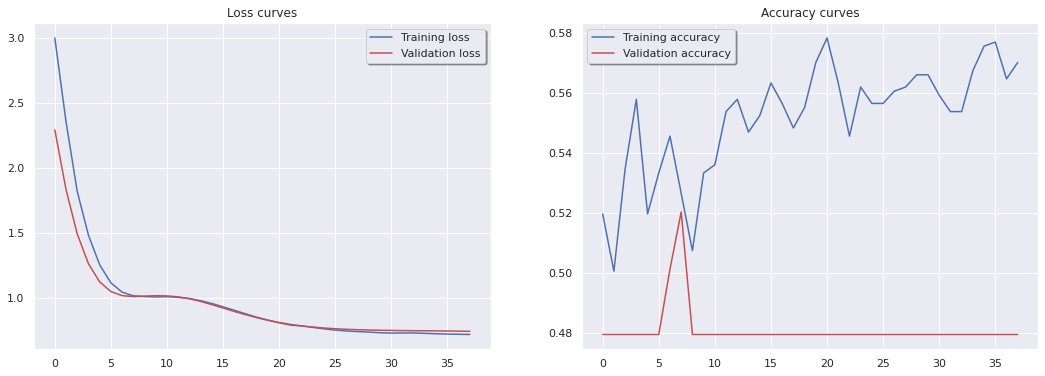

12/12 [==============================] - 1s 14ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_16 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_16 (Bat  (None, 30, 8)            32   

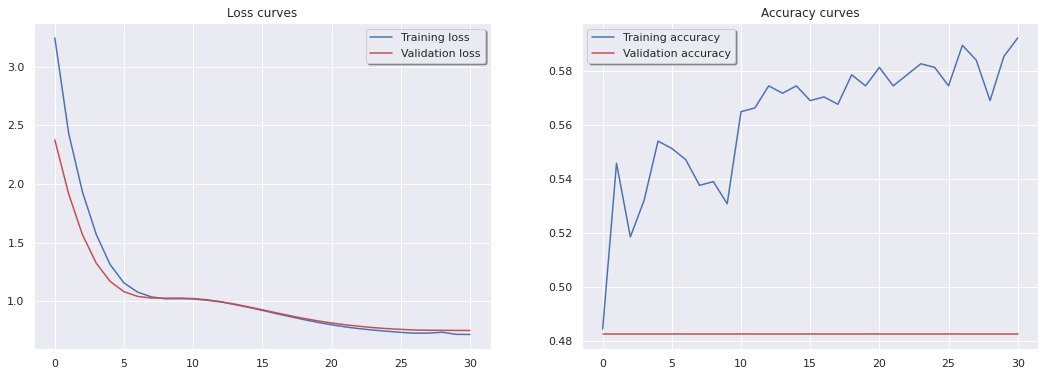

12/12 [==============================] - 1s 15ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_18 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_19 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_19 (Bat  (None, 30, 8)            32   

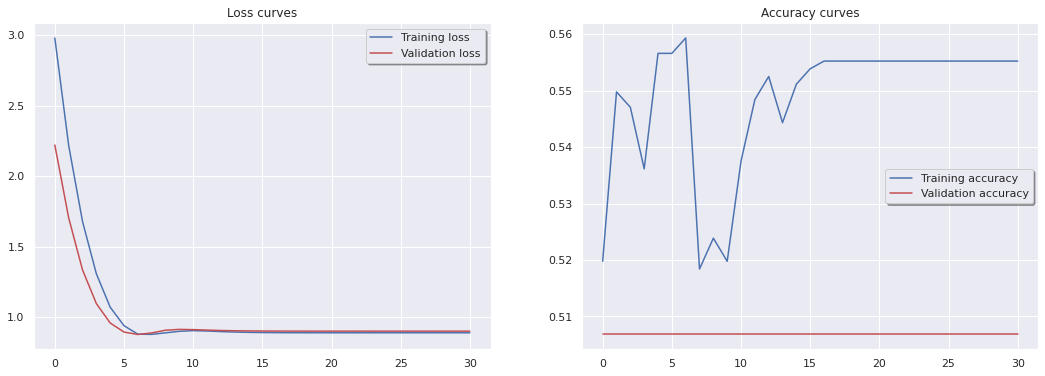

12/12 [==============================] - 1s 12ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_21 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_22 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_22 (Bat  (None, 30, 8)            32   

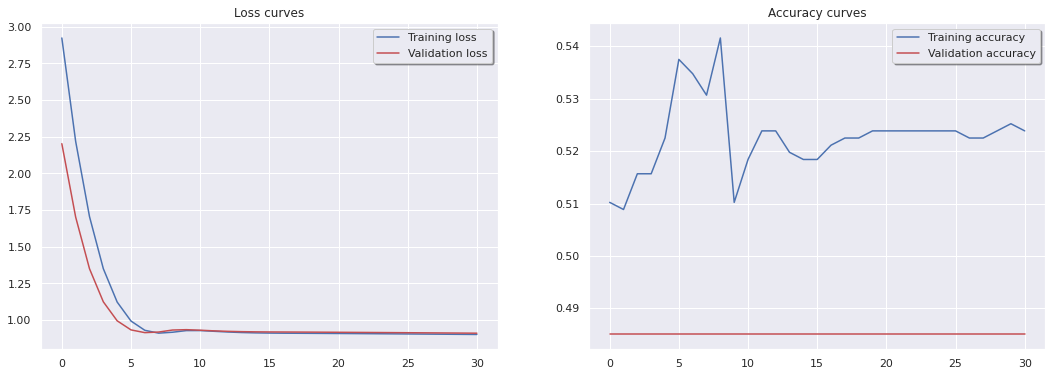

12/12 [==============================] - 1s 11ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_24 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_25 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_25 (Bat  (None, 30, 8)            32   

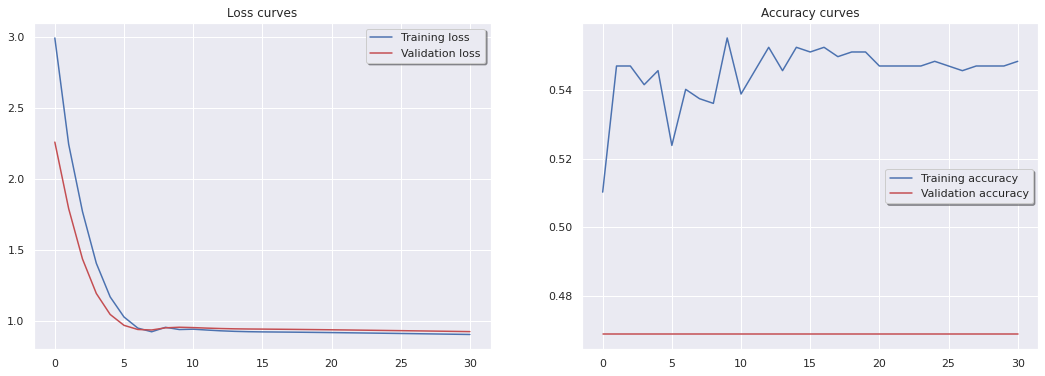

12/12 [==============================] - 1s 10ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_27 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_28 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_28 (Bat  (None, 30, 8)            32   

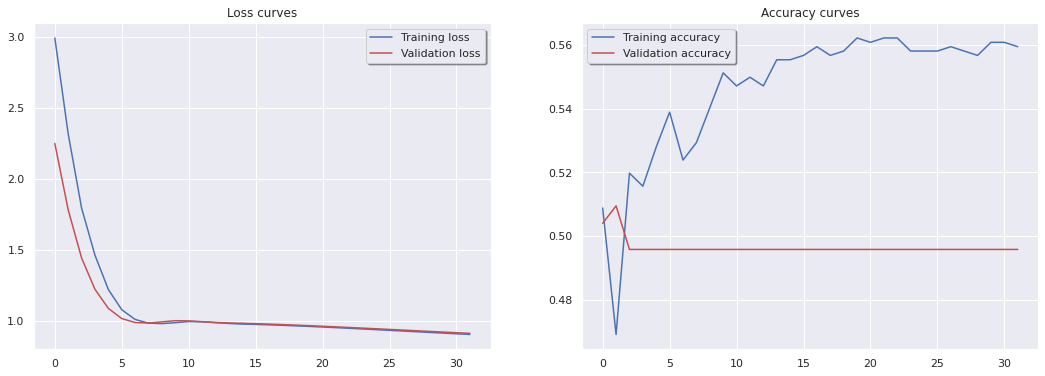

12/12 [==============================] - 1s 11ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_30 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_31 (Bat  (None, 30, 8)            32  

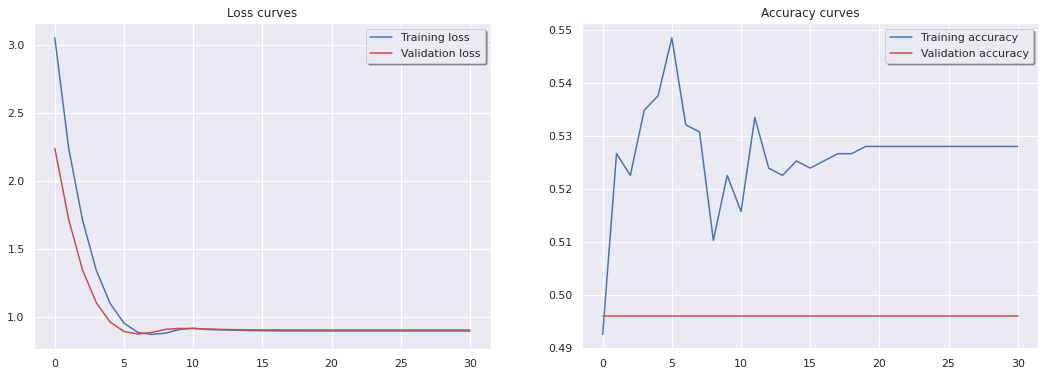

12/12 [==============================] - 1s 10ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_33 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_34 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_34 (Bat  (None, 30, 8)            32  

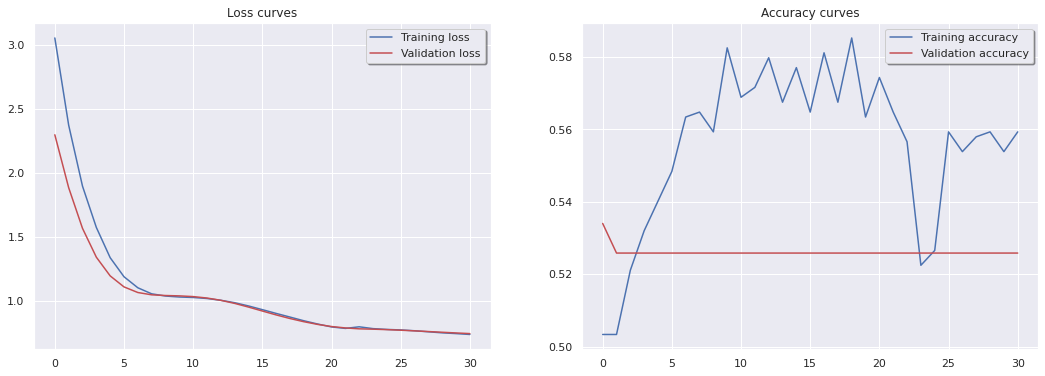

12/12 [==============================] - 1s 11ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_36 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_37 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_37 (Bat  (None, 30, 8)            32  

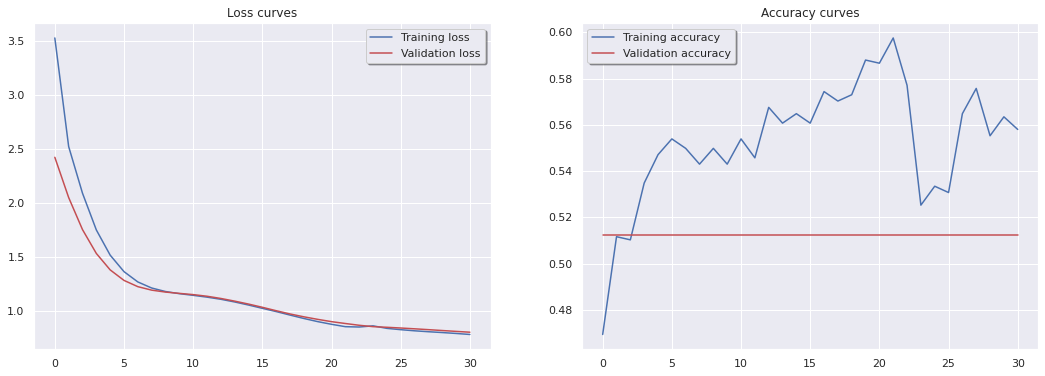

12/12 [==============================] - 1s 9ms/step
Train data dimensions: (733, 30, 16), (733, 1)
Test data dimensions: (367, 30, 16), (367, 1)
layers=[8, 8, 8, 1], train_examples=733, test_examples=367
batch = 733, timesteps = 30, features = 16, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 30, 8)             800       
                                                                 
 batch_normalization_39 (Bat  (None, 30, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_40 (LSTM)              (None, 30, 8)             544       
                                                                 
 batch_normalization_40 (Bat  (None, 30, 8)            32   

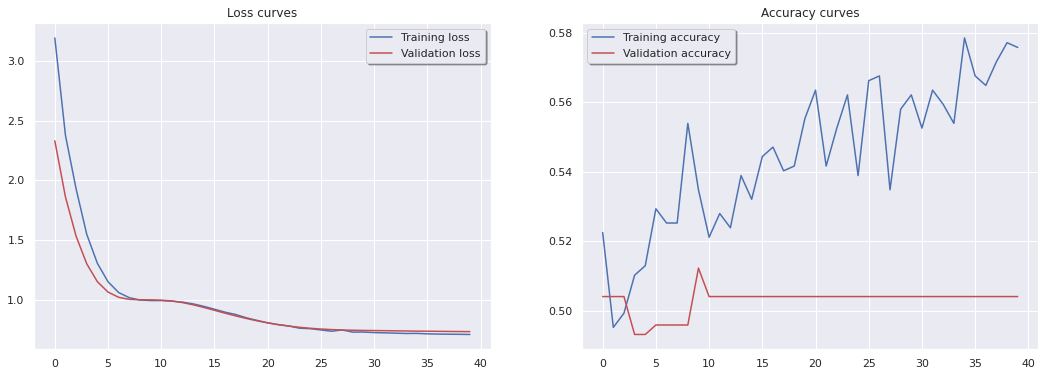

12/12 [==============================] - 1s 10ms/step


Direction        Up                          Down                      \
Metric    Precision    Recall  F1 Score Precision    Recall  F1 Score   
Coin                                                                    
BTC        0.516746  0.565445  0.540000  0.474684  0.426136  0.449102   
ETH        0.528497  0.536842  0.532637  0.494253  0.485876  0.490028   
BNB        0.505376  0.519337  0.512262  0.519337  0.505376  0.512262   
XRP        0.521472  0.449735  0.482955  0.490196  0.561798  0.523560   
ADA        0.540670  0.579487  0.559406  0.481013  0.441860  0.460606   
DOGE       0.472906  0.518919  0.494845  0.457317  0.412088  0.433526   
MATIC      0.509524  0.578378  0.541772  0.503185  0.434066  0.466077   
TRX        0.459596  0.522989  0.489247  0.508876  0.445596  0.475138   
LEO        0.473988  0.458101  0.465909  0.500000  0.515957  0.507853   
LTC        0.497462  0.538462  0.517150  0.505882  0.464865  0.484507   

Direction Weighted Avg F1  
Metric                     
Coin                       
BTC              0.496408  
ETH              0.512087  
BNB              0.512262  
XRP              0.502649  
ADA              0.513102  
DOGE             0.464436  
MATIC            0.504234  
TRX              0.481827  
LEO              0.487396  
LTC              0.500695

In [ ]:
classes = ['Up', 'Down']
metrics = ['Precision', 'Recall', 'F1 Score']
res = pd.DataFrame(columns = pd.MultiIndex.from_product([classes, metrics], names=['Direction', 'Metric']))
res['Coin'] = ''
res['Weighted Avg F1'] = np.nan

T = 30

# for coin in tqdm(coins, position=0):
for coin in coins:
    coin_df = lstm_df[(lstm_df['Coin'] == coin)].set_index(['Date']).merge(sentiment[['subjectivity', 'polarity', 'polxsub']], how='left', left_index=True, right_index=True)
    X = coin_df[features]
    y = coin_df[target]
    earliest_ix = np.where(X.index >= pd.Timestamp(earliest_date))[0][0] 

    X_train = X[(earliest_ix-T):-366]
    X_test = X[(-366-T):]
    y_train = y[(earliest_ix-T):-366]
    y_test = y[(-366-T):]

    for f in features:
      X_train_percs = (X_train[f].quantile(0.05), X_train[f].quantile(0.95))
      scaler = MinMaxScaler((-1, 1))
      X_train[f] = X_train[f].clip(X_train_percs[0], X_train_percs[1])
      X_train[f] = scaler.fit_transform(X_train[[f]])
      X_test[f] = X_test[f].clip(X_train_percs[0], X_train_percs[1])
      X_test[f] = scaler.transform(X_test[[f]])

    X_train_lstm, y_train_lstm = [], []
    for i in range(y_train.shape[0] - (T-1)):
        X_train_lstm.append(X_train.iloc[i:i+T].values)
        y_train_lstm.append(y_train.iloc[i + (T-1)])
    X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm).reshape(-1,1)
    print(f'Train data dimensions: {X_train_lstm.shape}, {y_train_lstm.shape}')

    X_test_lstm, y_test_lstm = [], []
    for j in range(y_test.shape[0] - (T-1)):
        X_test_lstm.append(X_test.iloc[j:j+T].values)
        y_test_lstm.append(y_test.iloc[j + (T-1)])
    X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm).reshape(-1,1)  

    print(f'Test data dimensions: {X_test_lstm.shape}, {y_test_lstm.shape}')
    
    LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
    M_TRAIN = X_train_lstm.shape[0]           # number of training examples (2D)
    M_TEST = X_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
    N = X_train_lstm.shape[2]                 # number of features
    BATCH = M_TRAIN                          # batch size
    EPOCH = 50                           # number of epochs
    LR = 5e-2                            # learning rate of the gradient descent
    LAMBD = 3e-2                         # lambda in L2 regularizaion
    DP = 0.0                             # dropout rate
    RDP = 0.0                            # recurrent dropout rate
    print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
    print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
    print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

    # Build the Model
    model = Sequential()
    model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
                  activation='tanh', recurrent_activation='hard_sigmoid',
                  kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                  dropout=DP, recurrent_dropout=RDP,
                  return_sequences=True, return_state=False,
                  stateful=False, unroll=False
                  ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[1],
                  activation='tanh', recurrent_activation='hard_sigmoid',
                  kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                  dropout=DP, recurrent_dropout=RDP,
                  return_sequences=True, return_state=False,
                  stateful=False, unroll=False
                  ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[2],
                  activation='tanh', recurrent_activation='hard_sigmoid',
                  kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                  dropout=DP, recurrent_dropout=RDP,
                  return_sequences=False, return_state=False,
                  stateful=False, unroll=False
                  ))
    model.add(BatchNormalization())
    model.add(Dense(units=LAYERS[3], activation='sigmoid'))

    # Compile the model with Adam optimizer
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=LR))
    print(model.summary())

    # Define a learning rate decay method:
    lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=0, 
                                factor=0.5, min_lr=1e-8)
    # Define Early Stopping:
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    # Train the model. 
    # The dataset is small for NN - let's use test_data for validation
    start = time()
    History = model.fit(X_train_lstm, y_train_lstm,
                        epochs=EPOCH,
                        batch_size=BATCH,
                        validation_split=0.0,
                        validation_data=(X_test_lstm[:M_TEST], y_test_lstm[:M_TEST]),
                        shuffle=True,verbose=0,
                        callbacks=[lr_decay, early_stop])
    print('-'*65)
    print(f'Training was completed in {time() - start:.2f} secs')
    print('-'*65)
    # Evaluate the model:
    train_loss, train_acc = model.evaluate(X_train_lstm, y_train_lstm,
                                          batch_size=M_TRAIN, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_lstm[:M_TEST], y_test_lstm[:M_TEST],
                                        batch_size=M_TEST, verbose=0)
    print('-'*65)
    print(f'train accuracy = {round(train_acc * 100, 4)}%')
    print(f'test accuracy = {round(test_acc * 100, 4)}%')
    print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

    # Plot the loss and accuracy curves over epochs:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].plot(History.history['loss'], color='b', label='Training loss')
    axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
    axs[0].set_title("Loss curves")
    axs[0].legend(loc='best', shadow=True)
    axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
    axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
    axs[1].set_title("Accuracy curves")
    axs[1].legend(loc='best', shadow=True)
    plt.show()

    y_pred_lstm = model.predict(X_test_lstm)
    y_pred_lstm = np.where((y_pred_lstm[1:] / y_pred_lstm[:-1] - 1) > 0, 1, 0).flatten()
    y_pred_lstm = np.insert(y_pred_lstm, 0, [0])
    report = classification_report(y_test_lstm, y_pred_lstm, output_dict=True)
    vals = [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], 
                    report['1']['precision'], report['1']['recall'], report['1']['f1-score'], 
                    coin, report['weighted avg']['f1-score']]
    res = res.append(dict(zip(res.columns, vals)), ignore_index=True)
res.set_index('Coin')